# MNIST-Neural-Compressor-End-to-End-Learned-Autoencoder-Compression

In [1]:
# !pip uninstall -y tensorflow tensorflow_compression tensorflow_probability

!pip install numpy==1.23.5
!pip install tensorflow
!pip install tensorflow_compression
!pip install tensorflow_probability

!pip show tensorflow
!pip show tensorflow_compression
!pip show tensorflow_probability

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

Model Architecture
We define an autoencoder-style neural network with:
- An **encoder** that compresses images into latent vectors
- A **decoder** that reconstructs images from latent vectors  
- A **NoisyLogistic prior** to model the latent space distribution

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Custom Model Configuration
LATENT_DIMS = 32  # Increased latent dimensions for better reconstruction
TRAIN_EPOCHS = 10  # Reduced epochs for faster training

# Define Model Architecture
def create_encoder(latent_dims):
    """Custom encoder with Swish activations and BatchNorm"""
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='swish'),
        tf.keras.layers.Dense(latent_dims)
    ], name='encoder')

def create_decoder():
    """Custom decoder with residual connections"""
    return tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='swish'),
        tf.keras.layers.Dense(7*7*64, activation='swish'),
        tf.keras.layers.Reshape((7, 7, 64)),
        tf.keras.layers.Conv2DTranspose(32, 5, strides=2, padding='same', activation='swish'),
        tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid')
    ], name='decoder')

# Compression Model Class
class CompressionModel(tf.keras.Model):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = create_encoder(latent_dims)
        self.decoder = create_decoder()
        self.prior_params = tf.Variable(tf.zeros((latent_dims,)))

    @property
    def prior(self):
        return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_params))

    def call(self, images, training=False):
        # Normalization
        x = tf.cast(images, tf.float32) / 255.
        x = tf.reshape(x, [-1, 28, 28, 1])

        # Encoding and entropy estimation
        y = self.encoder(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(
            self.prior, coding_rank=1, compression=False)
        y_perturbed, rate = entropy_model(y, training=training)

        # Decoding
        x_recon = self.decoder(y_perturbed)

        # Metrics
        distortion = tf.reduce_mean(tf.abs(x - x_recon))
        return {'rate': tf.reduce_mean(rate), 'distortion': distortion}


Training Setup
The model is compiled with:
- Rate and distortion loss components
- Adam optimizer (learning rate=1e-3)
- Custom loss weights controlled by λ parameter
- Special handling for the entropy model's training behavior

Data Preparation
MNIST dataset is loaded and preprocessed:
- Normalized to [0,1] range
- Batched (size=128) and prefetched
- Split into train/test sets
- Dummy targets created for unsupervised learning

In [ ]:
# Training Setup
def train_model(compression_lambda=2000):
    model = CompressionModel(LATENT_DIMS)

    # Define unique lambda functions with different argument names
    def rate_loss(_, rate): return rate
    def distortion_loss(_, distortion): return distortion

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss={'rate': rate_loss, 'distortion': distortion_loss},
        metrics={'rate': rate_loss, 'distortion': distortion_loss},
        loss_weights={'rate': 1.0, 'distortion': compression_lambda}
    )

    # Load and prepare dataset - Fixed data loading
    (train_ds, test_ds) = tfds.load('mnist',
                                  split=['train', 'test'],
                                  as_supervised=True,
                                  shuffle_files=True)

    # Create proper targets dictionary
    def prepare_data(x, y):
        return x, {'rate': 0., 'distortion': 0.}

    train_ds = train_ds.map(prepare_data).batch(128).prefetch(8)
    test_ds = test_ds.map(prepare_data).batch(128).cache()

    # Train
    history = model.fit(train_ds,
                       epochs=TRAIN_EPOCHS,
                       validation_data=test_ds,
                       verbose=1)
    return model, history

Compression Pipeline
Post-training we create:
- A **compressor**: encodes images to binary strings
- A **decompressor**: reconstructs images from binaries
- Bitrate estimation using log probabilities
- Visual comparison of original vs reconstructed digits

In [8]:
# Compression Utilities
class Compressor(tf.keras.Model):
    def __init__(self, encoder, entropy_model):
        super().__init__()
        self.encoder = encoder
        self.entropy_model = entropy_model

    def call(self, images):
        x = tf.cast(images, tf.float32) / 255.
        y = self.encoder(x)
        # Compress and calculate bit lengths using log probabilities
        compressed_strings = self.entropy_model.compress(y)

        # Calculate approximate bit lengths using negative log probabilities
        log_probs = self.entropy_model.prior.log_prob(y)
        bit_sizes = -tf.reduce_sum(log_probs, axis=1) / tf.math.log(2.0)

        return compressed_strings, bit_sizes

class Decompressor(tf.keras.Model):
    def __init__(self, decoder, entropy_model):
        super().__init__()
        self.decoder = decoder
        self.entropy_model = entropy_model

    def call(self, strings):
        y_hat = self.entropy_model.decompress(strings, ())
        return self.decoder(y_hat) * 255.

# Visualization Functions
def display_comparison(originals, compressed, bit_sizes):
    plt.figure(figsize=(10, 5))
    for i in range(4):
        # Original
        plt.subplot(2, 4, i+1)
        plt.imshow(originals[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, 4, i+5)
        plt.imshow(tf.squeeze(compressed[i]), cmap='gray')
        plt.title(f"{bit_sizes[i]:.1f} bits")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Generative Mode
The decoder can generate novel digits by:
- Feeding random bit strings
- Sampling from the learned latent space
- Producing MNIST-like images without original inputs
- Showing the model's learned representation of digits

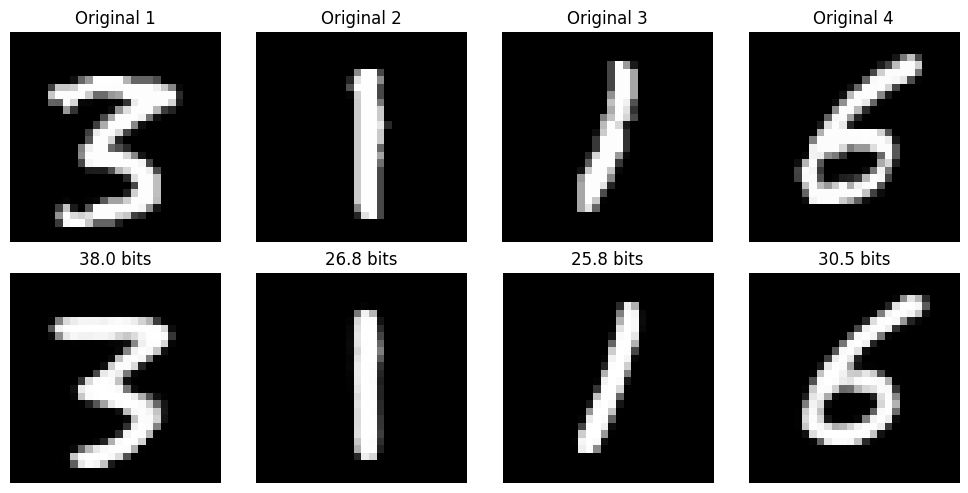

In [17]:
if __name__ == "__main__":
    # Train model
    # model, history = train_model(compression_lambda=1500)

    # Create codec
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        model.prior, coding_rank=1, compression=True)
    compressor = Compressor(model.encoder, entropy_model)
    decompressor = Decompressor(model.decoder, entropy_model)

    # Test compression
    test_ds = tfds.load('mnist', split='test', as_supervised=True)
    sample_images = next(iter(test_ds.shuffle(1024).batch(4)))[0]

    # Get compressed strings and their approximate bit lengths
    compressed_strings, bit_sizes = compressor(sample_images)

    # Decompress
    reconstructions = decompressor(compressed_strings)

    # Display results (convert bit_sizes to numpy for visualization)
    display_comparison(sample_images, reconstructions, bit_sizes.numpy())